#Hate Speech Detection (BERT) and Topic Modelling (BERTopic)

Import relevant libraries

In [ ]:
%%capture
!pip install tensorflow-text
# !pip uninstall -y protobuf python3-protobuf
# !pip install -U protobuf==3.13.*

In [ ]:
"""Author: Melwyn D Souza, Reg No: R00209495"""
import tensorflow_text as text
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display_html
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tensorflow import keras
from tensorflow.keras.layers import *
from collections import Counter

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

from sklearn.utils import shuffle
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


#HateXplain Data
This data consists of 3 classes same as davidsons data above, davidson data was very imbalanced, this one is fairly balanced 

I have done a lot of manual handling of data and finally have two colmuns

tweet, class

classes: normal, hatespeech, offensive 

normal = 0
hatespeech = 1
offensive = 2



In [ ]:
# import pandas as pd
# df = pd.read_csv("gdrive/My Drive/Thesis/dataset/hateXplain_data.csv")


# df_hs = df[df['class']==1]
# df_ns = df[df['class']==0]

# df_ns = df_ns.sample(len(df_hs))
# # df_neit = df_neit.sample(len(df_hs))


# df  = pd.concat([df_hs,df_ns])

# df["class"].value_counts()
# df.to_csv("gdrive/My Drive/Thesis/dataset/hateXplain_data_2c_onlyhate.csv")

def loadhatexplain():
  df = pd.read_csv("gdrive/My Drive/Thesis/dataset/hateXplain_data_2c_onlyhate.csv")


  X_train, X_rem, y_train, y_rem = train_test_split(df['tweet'], df['class'], stratify=df['class'], test_size=0.4, random_state=42)
  X_train, X_rem, y_train, y_rem = train_test_split(df['tweet'], df['class'], test_size=0.4, random_state=42)

  # Split the remaining data into validation and testing sets
  X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)
  # print()
  # Check the number of samples in each set
  print(f"Training data statistics: {Counter(y_train)}")
  print(f"Validation data statistics: {Counter(y_val)}")
  print(f"Testing data statistics: {Counter(y_test)}")

  return df, X_train, X_val, X_test, y_train, y_val, y_test

Data Pre-Processing

# Davidson Data

The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:

`count` = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

`hate_speech` = number of CF users who judged the tweet to be hate speech.

`offensive_language` = number of CF users who judged the tweet to be offensive.

`neither` = number of CF users who judged the tweet to be neither offensive nor non-offensive.

`class` = class label for majority of CF users.
  0 - hate speech
  1 - offensive  language
  2 - neither

In [ ]:
def loadData():

  # df = pd.read_csv("gdrive/My Drive/Thesis/dataset/davidson_data.csv")
  df = pd.read_csv("gdrive/My Drive/Thesis/dataset/davidson_data_gold_hs4163.csv")
  # df = pd.read_csv("gdrive/My Drive/Thesis/dataset/train.csv")
  df  = df[["tweet", "class"]]
  # df.head(10)
  # df['class'].value_counts()

  # df = df.sample(n=1024)

  #Clean the text by removing mentions, hashtags, links, and other unwanted characters
  def clean_text(txt):
      txt = re.sub(r'@[A-Za-z0-9]+', '', txt)
      txt = re.sub(r'#', '', txt)
      txt = re.sub(r'RT[\s]+', '', txt)
      txt = re.sub(r'https?:\/\/\S+', '', txt)
      txt = re.sub(r'\n', '', txt)
      return txt

  df['tweet'] = df['tweet'].apply(clean_text)

  # df_hs = df[df['class']==0]
  # df_nhs = df[df['class']==1]
  # df_neit = df[df['class']==2]

  # df_nhs = df_nhs.sample(len(df_hs))
  # df_neit = df_neit.sample(len(df_hs))

  # df  = pd.concat([df_hs,df_nhs,df_neit])
 
  print(f"Total value counts:\n{df['class'].value_counts()}")

  X_train, X_rem, y_train, y_rem = train_test_split(df['tweet'], df['class'], stratify=df['class'], test_size=0.4, random_state=42)
  X_train, X_rem, y_train, y_rem = train_test_split(df['tweet'], df['class'], test_size=0.4, random_state=42)

  # Split the remaining data into validation and testing sets
  X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)
  print()
  # Check the number of samples in each set
  print(f"Training data statistics: {Counter(y_train)}")
  print(f"Validation data statistics: {Counter(y_val)}")
  print(f"Testing data statistics: {Counter(y_test)}")

  return df, X_train, X_val, X_test, y_train, y_val, y_test

# loadData()


# df = pd.read_csv("gdrive/My Drive/Thesis/dataset/davidson_data.csv")
# # df  = df[["tweet", "new"]]
# # df['new'].value_counts()
# # df2 = df.rename({'new': 'class'}, axis=1) 
# # df2.to_csv("gdrive/My Drive/Thesis/dataset/davidson_data_gold_hs4163.csv")
# df  = df[["tweet", "class"]]
# df_hs = df[df['class']==0]
# df_nhs = df[df['class']==1]
# df_neit = df[df['class']==2]

# df_nhs = df_nhs.sample(2733)
# # df_neit = df_neit.sample(len(df_hs))

# df  = pd.concat([df_hs,df_neit])


# def a(r):
#   if r == 2:
#     return 1
#   return r
# df['new'] = df['class'].apply(a)
# df['new'].value_counts()
# df  = df[["tweet", "new"]]
# df2 = df.rename({'new': 'class'}, axis=1) 
# df2
# df2.to_csv("gdrive/My Drive/Thesis/dataset/davidson_data_gold_hs4163.csv")

In [ ]:
def tweeteval():
  df = pd.read_csv("gdrive/My Drive/Thesis/dataset/tweeteval.csv")
  df  = df[["tweet", "class"]]
  # df.head(10)
  # df['class'].value_counts()

  # df = df.sample(n=1024)

  #Clean the text by removing mentions, hashtags, links, and other unwanted characters
  def clean_text(txt):
      txt = re.sub(r'@[A-Za-z0-9]+', '', txt)
      txt = re.sub(r'#', '', txt)
      txt = re.sub(r'RT[\s]+', '', txt)
      txt = re.sub(r'https?:\/\/\S+', '', txt)
      txt = re.sub(r'\n', '', txt)
      return txt

  df['tweet'] = df['tweet'].apply(clean_text)

  # df_hs = df[df['class']==0]
  # df_nhs = df[df['class']==1]
  # df_neit = df[df['class']==2]

  # df_nhs = df_nhs.sample(len(df_hs))
  # df_neit = df_neit.sample(len(df_hs))

  # df  = pd.concat([df_hs,df_nhs,df_neit])
 
  print(f"Total value counts:\n{df['class'].value_counts()}")

  X_train, X_rem, y_train, y_rem = train_test_split(df['tweet'], df['class'], stratify=df['class'], test_size=0.4, random_state=42)
  X_train, X_rem, y_train, y_rem = train_test_split(df['tweet'], df['class'], test_size=0.4, random_state=42)

  # Split the remaining data into validation and testing sets
  X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)
  print()
  # Check the number of samples in each set
  print(f"Training data statistics: {Counter(y_train)}")
  print(f"Validation data statistics: {Counter(y_val)}")
  print(f"Testing data statistics: {Counter(y_test)}")

  return df, X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
bert_pre_process = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")#,trainable=True)

In [ ]:
def get_txt_embeddings(txt):
  pre_processed_txt = bert_pre_process(txt)
  return bert_encoder(pre_processed_txt)["pooled_output"]

The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.

default represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.

encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output

Total value counts:
0    5217
1    3783
Name: class, dtype: int64

Training data statistics: Counter({0: 3094, 1: 2306})
Validation data statistics: Counter({0: 1061, 1: 739})
Testing data statistics: Counter({0: 1062, 1: 738})


,tweet,class
0,nice new signage. Are you not concerned by Be...,0
1,A woman who you fucked multiple times saying y...,1
2,real talk do you have eyes or were they goug...,1
3,your girlfriend lookin at me like a groupie in...,1
4,Hysterical woman like,0
5,Me flirting- So tell me about your father...,0
6,The Philippine Catholic bishops' work for migr...,0
7,I AM NOT GOING AFTER YOUR EX BF YOU LIEING SAC...,1
8,When cuffin season is finally over,0
9,"Send home migrants not in need of protection, ...",1


,tweet,class
8990,Immigrant parents of companies like the annual...,0
8991,When the gangbang goes horribly wrong,0
8992,It's April fools day but I clown you bitches e...,0
8993,You call it whatever you want -You praise hoe...,1
8994,Happiest of birthdays to the main hoe 😏💃🏻 I ho...,0
8995,Oooohhhh bitch didn't even listen to the dead ...,0
8996,Good Luck More Americans WalkAwayFromDemocra...,0
8997,Bitch you can't keep up so stop trying,1
8998,Japan is always operating under the prem...,0
8999,hi Best l see someone fucking girl comment ba...,1


Labels >> [0 1]
Two classes [0 1] final layer
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}    

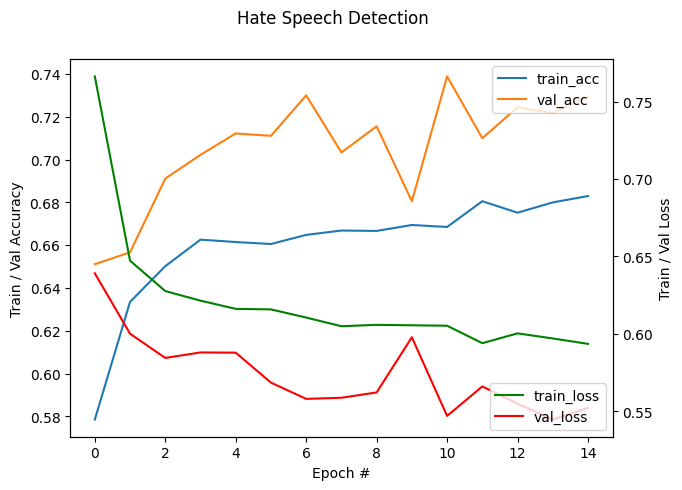

57/57 [==============================] - 20s 344ms/step
[0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1]
[0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1]
 - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - -  - - 
Confusion Matrix:
[[893 169]
 [333 405]]


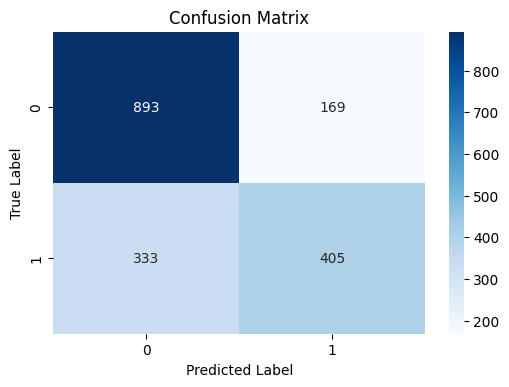

   label  specificity    recall  precision   f_score
0      0     0.548780  0.840866   0.728385  0.780594
1      1     0.840866  0.548780   0.705575  0.617378
Precision: 0.72
Recall: 0.72
F1 score: 0.71


In [ ]:
def HSD():
  df, X_train, X_val, X_test, y_train, y_val, y_test = tweeteval()
  # df, X_train, X_val, X_test, y_train, y_val, y_test = loadData()
  # df, X_train, X_val, X_test, y_train, y_val, y_test = loadhatexplain()
  display_html(df.head(10))
  display_html(df.tail(10))

  # print(df.groupby("class").describe())
  labels = df['class'].unique()
  print(f"Labels >> {labels}")
  epochs = 15
  # steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
  # num_train_steps = steps_per_epoch*epochs
  # num_warmup_steps = int(0.1*num_train_steps)

  # init_lr = 3e-5
  # optimizer = optimization.create_optimizer(init_lr=init_lr,
  #                                           num_train_steps=num_train_steps,
  #                                           num_warmup_steps=num_warmup_steps,
  #                                           optimizer_type='adamw')
  
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  txt_embeddings = get_txt_embeddings(text_input)
  # print(txt_embeddings)

  # Neural network layers - dropout layer
  # l1 = tf.keras.layers.Dropout(0.3, name="dropout")(txt_embeddings)

  l0 = tf.keras.layers.Dropout(0.3, name="dropout")(txt_embeddings)
  l1 = tf.keras.layers.Dense(768, activation='relu', name="relu")(l0)

  if  df['class'].nunique() == 2:
    print(f"Two classes {labels} final layer")
    l2 = tf.keras.layers.Dense(2, activation='softmax', name="final_layer")(l1)
  elif df['class'].nunique() > 2:
    print(f"classes {labels} final layer")
    l2 = tf.keras.layers.Dense(df['class'].nunique(), activation='softmax', name="final_layer")(l1)
  
  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs=[l2])
  model.summary()

  # # METRICS = 
  if  df['class'].nunique() == 2:
    print(f"Two classes {labels} >> optimiser") 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  elif df['class'].nunique() > 2:
    print(f"Classes {labels} >> optimiser") 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, epochs=epochs, batch_size = 32, validation_data=(X_val, y_val))

  #plotting accuracy and losses of training and validate data
  fig = plt.figure(figsize=(7,5))
  fig.suptitle("Hate Speech Detection")
  ax1 = fig.add_subplot()
  ax2 = ax1.twinx()

  ax2.plot(np.arange(0, epochs), history.history["loss"], color='green', label="train_loss")
  ax2.plot(np.arange(0, epochs), history.history["val_loss"], color='red', label="val_loss")
  ax1.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
  ax1.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
  ax1.set_ylabel("Train / Val Accuracy")
  ax2.set_ylabel("Train / Val Loss")
  ax1.set_xlabel("Epoch #")
  ax1.legend(loc ='upper right')
  ax2.legend(loc= 'lower right')
  plt.show()

  y_pred = model.predict(X_test) 
  y_pred = np.argmax(y_pred, axis=1)
  # y_pred = y_pred.flatten()
  # X_test.head(10)
  # print(X_test[:10])
  print(np.array(y_test[:25]))
  print(np.array(y_pred[:25]))

  y_test = np.array(y_test)
  y_pred = np.array(y_pred)
  # y_pred = np.where(y_pred>0.5,1,0)

  # create confusion matrix
  confuse_matrix = confusion_matrix(y_test, y_pred)
  print(" - - "*20)
  print("Confusion Matrix:")
  print(confuse_matrix)

  # create heatmap
  # import seaborn as sns
  # import matplotlib.pyplot as plt

  # confuse_matrix = [[   0,  251,   24], [   0, 3776,   91], [   0,  503,  312]]

  sns.heatmap(confuse_matrix, annot=True, fmt="d", cmap="Blues")
  plt.title("Confusion Matrix")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

  result = []
  for label in labels:
    # precision, recall, f_score, support = precision_recall_fscore_support(np.array(y_test)==label,np.array(y_pred)==label)
    precision, recall, f_score, support = precision_recall_fscore_support(y_test==label, y_pred==label)
    result.append([label, recall[0], recall[1], precision[1], f_score[1]])
  
  result_df = pd.DataFrame(result, columns=["label", "specificity", "recall", "precision", "f_score"])

  print(result_df)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')

  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")
  print(f"F1 score: {f1:.2f}")

HSD()
